# Pytorch implementation
---

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable
import torchvision.datasets as dataset

from IPython.core.debugger import set_trace
import matplotlib.pyplot as plt
from PIL import Image

import os
import numpy as np

### Resizing images

The original images were ~3000x3000. I have resized it to 300x300 for computational efficiency

In [2]:
sz = (300,300) #specify the final size

In [14]:
# fn1 = !ls data/normal
# fn2 = !ls data/condition

In [3]:
# for n in fn1:
# #     set_trace()
# #     print(n)
#     im = Image.open(f'data/normal/{n}')
#     im.thumbnail(sz,Image.ANTIALIAS)
#     im.save(f'data/montgomery_china_resized/normal/{n}',format='png')
    

In [4]:
# for n in fn2:
# #     set_trace()
# #     print(n)
#     im = Image.open(f'data/condition/{n}')
#     im.thumbnail(sz,Image.ANTIALIAS)
#     im.save(f'data/montgomery_china_resized/condition/{n}',format='png')

---

We have 800 X-ray images. We have split it into train (680 images) and validation (120 images). 

### Sample image

In [68]:
path = 'data/'

In [69]:
sample = plt.imread('data/montgomery_china_resized/train/normal/CHNCXR_0001_0.png')

In [70]:
sample.shape

(291, 300, 3)

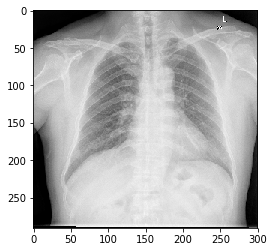

In [15]:
plt.imshow(sample)

### Transforms

Below are some few kind of transforms that are generally used for data augmentation

In [16]:
sample = Image.open('data/montgomery_china_resized/train/normal/CHNCXR_0001_0.png')

#### Center Crop

In [57]:
t = transforms.CenterCrop(200)

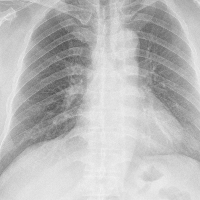

In [58]:
t(sample)

#### Random Crop

In [63]:
t = transforms.RandomCrop(250)

In [66]:
t(sample).size

(250, 250)

#### Horizontal Flip

In [23]:
t = transforms.RandomHorizontalFlip()

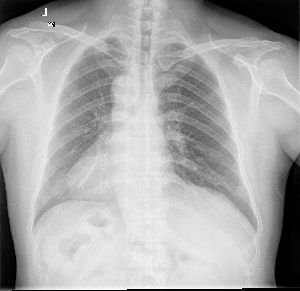

In [25]:
t(sample)

#### Vertical Flip

In [26]:
t = transforms.RandomVerticalFlip()

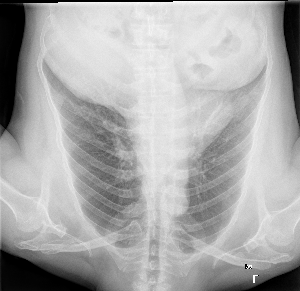

In [27]:
t(sample)

#### Rotation

In [51]:
t = transforms.RandomRotation((0,20))

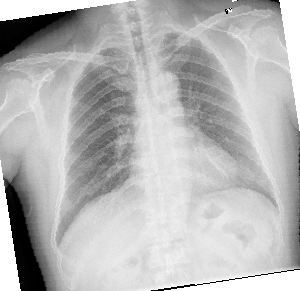

In [52]:
t(sample)

#### Defining transforms for this dataset

In [136]:
# Specifying your transforms
transform = transforms.Compose([
    transforms.RandomCrop(290),
#     transforms.RandomRotation(1),
    transforms.ToTensor()
])

## Data Loader

In [141]:
batch_size = 8

This method of data loader is used if we have 2 folders train and validation and there are separate folders for each class within them

In [142]:
#for training
traindir = os.path.join('data/montgomery_china_resized/', 'train')

In [143]:
train = dataset.ImageFolder(traindir, transform)

In [144]:
train_loader = torch.utils.data.DataLoader(train, batch_size=16, shuffle=True)

In [119]:
#for validation
valdir = os.path.join('data/montgomery_china_resized/', 'valid')
valid = dataset.ImageFolder(valdir, transform)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

---

In [97]:
layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))

In [145]:
xmb,ymb = next(iter(train_loader))

ValueError: empty range for randrange() (0,-13, -13)

In [99]:
xmb.size()

torch.Size([3, 280, 280])

In [90]:
layer1(xmb)

ValueError: Expected 4D tensor as input, got 3D tensor instead.

## Building your CNN network

In [133]:
# CNN Model (2 conv layer)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(72*72*32, 2)
        
    def forward(self, x):
#         set_trace()
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [134]:
cnn = CNN() #instantiating your CNN class
#shifting it to gpu

criterion = nn.CrossEntropyLoss() #defining your loss
optimizer = torch.optim.Adam(cnn.parameters(), lr=.001) #defining your optimizer

---
## Training of the network

In [135]:
for epoch in range(3):
    for i, (images, labels) in enumerate(train_loader):
#         set_trace()
        images = Variable(images)
        labels = Variable(labels)
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f' 
                   %(epoch+1, num_epochs, i+1, len(train)//batch_size, loss.data[0]))

ValueError: empty range for randrange() (0,-33, -33)

---
## Predicting on validation set

In [148]:
cnn.eval()    # Change model to 'eval' mode (BN uses moving mean/var).
correct = 0
total = 0
for images, labels in valid_loader:
    images = Variable(images).cuda()
    outputs = cnn(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted.cpu() == labels).sum()

print('Test Accuracy of the model on the 10000 test images: %d %%' % (100 * correct / total))

# Save the Trained Model
torch.save(cnn.state_dict(), 'cnn.pkl')

Test Accuracy of the model on the 10000 test images: 45 %


---